<a href="https://colab.research.google.com/github/MuhammadBinTariq/ATML_PA0/blob/main/Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 5: Modality Gap in CLIP


### Experimentation

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import STL10

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bovz992i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bovz992i
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=8edb8dfad63f712169b64a9bcd3a9d1f3a92ba95ead7320dbe62a106ea37b580
  Stored in directory: /tmp/pip-ephem-wheel-cache-cql609th/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.87 MiB | 16.88 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [ ]:
# Load OpenAI's CLIP model
import clip
from PIL import Image

# Load model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the STL-10 dataset
test_dataset = STL10(root='./data', split='test', download=True, transform=preprocess)
visual_test_dataset = STL10(root='./data', split='test', download=True)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 66.1MiB/s]
100%|██████████| 2.64G/2.64G [01:14<00:00, 35.6MB/s]


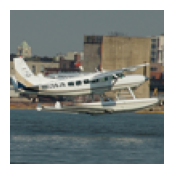

In [ ]:
# Get a single sample (image, label) [for experimentation purposes]
image, true_label_index = test_dataset[5433]
# 'image' is now a preprocessed tensor. 'true_label_index' is an integer (0-9).

# model.encode_image expects a batch
image_input = image.unsqueeze(0).to(device)

# Visualize the image for ourselves
import matplotlib.pyplot as plt

image, _ = visual_test_dataset[5433]
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Think of the class names as questions. We are 'prompting' our model to tell
# whether an image looks more like 'class_1' or 'class_2' or ...

# Plain labels (questions)
questions = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

# Basic Prompt
prompts = [f"a photo of a {name}" for name in questions]
# Tokenize and encode all prompts
text_inputs = clip.tokenize(prompts).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [ ]:
# Encode the single image
with torch.no_grad():
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)

# Calculate similarity (logit scale is from CLIP paper)
logit_scale = 100.0   # This is like 'temperature'
similarity = (logit_scale * image_features @ text_features.T).softmax(dim=-1)
# similarity is now a tensor of shape [1, 10] holding probabilities

# Convert the similarities to percentages for readability
similarity_percent = similarity[0] * 100

In [ ]:
# print(similarity)
# print(similarity[0])
print(similarity_percent)

tensor([8.7215e+01, 1.2495e+00, 1.3846e-01, 5.5816e-02, 3.6304e-02, 1.3741e-01,
        1.3429e-01, 2.0658e-01, 1.0812e+01, 1.5220e-02])


In [ ]:
# Get the predicted class index (the one with the highest probability)
predicted_index = similarity.argmax(dim=-1).item()

# Get the confidence for the predicted class
confidence = similarity[0][predicted_index].item()

# Get the true class name
true_class = questions[true_label_index]

print(f"\nImage's True Label: '{true_class}' (index {true_label_index})")
print(f"Model's Prediction: '{questions[predicted_index]}' (index {predicted_index}) with {confidence:.2%} confidence")
print("\nSimilarity scores for all classes:")
for i, (prompt, percent) in enumerate(zip(prompts, similarity_percent)):
    # Mark the true and predicted labels
    marker = ""
    if i == true_label_index:
        marker = " <- TRUE LABEL"
    if i == predicted_index:
        marker = " <- PREDICTION"
    print(f"{prompt:25} : {percent.item():5.2f}%{marker}")


Image's True Label: 'airplane' (index 0)
Model's Prediction: 'airplane' (index 0) with 87.21% confidence

Similarity scores for all classes:
a photo of a airplane     : 87.21% <- PREDICTION
a photo of a bird         :  1.25%
a photo of a car          :  0.14%
a photo of a cat          :  0.06%
a photo of a deer         :  0.04%
a photo of a dog          :  0.14%
a photo of a horse        :  0.13%
a photo of a monkey       :  0.21%
a photo of a ship         : 10.81%
a photo of a truck        :  0.02%


In [ ]:
plain_inputs = clip.tokenize(questions).to(device)

with torch.no_grad():
  plain_text_features = model.encode_text(plain_inputs)
  plain_text_features /= plain_text_features.norm(dim=-1, keepdim=True)

with torch.no_grad():
  plain_image_features = model.encode_image(image_input)
  plain_image_features /= plain_image_features.norm(dim=-1, keepdim=True)

plain_similarity = (logit_scale * plain_image_features @ plain_text_features.T).softmax(dim=-1)
plain_similarity_percent = plain_similarity[0] * 100

plain_predicted_index = plain_similarity.argmax(dim=-1).item()
plain_confidence = plain_similarity[0][plain_predicted_index].item()

plain_true_class = questions[true_label_index]

print(f"\nImage's True Label: '{plain_true_class}' (index {true_label_index})")
print(f"Model's Prediction: '{questions[plain_predicted_index]}' (index {plain_predicted_index}) with {plain_confidence:.2%} confidence")
print("\nSimilarity scores for all classes:")
for i, (prompt, percent) in enumerate(zip(questions, plain_similarity_percent)):
    # Mark the true and predicted labels
    marker = ""
    if i == true_label_index:
        marker = " <- TRUE LABEL"
    if i == plain_predicted_index:
        marker = " <- PREDICTION"
    print(f"{prompt:25} : {percent.item():5.2f}%{marker}")


Image's True Label: 'airplane' (index 0)
Model's Prediction: 'airplane' (index 0) with 78.21% confidence

Similarity scores for all classes:
airplane                  : 78.21% <- PREDICTION
bird                      :  2.44%
car                       :  0.18%
cat                       :  0.04%
deer                      :  0.06%
dog                       :  0.13%
horse                     :  0.11%
monkey                    :  0.24%
ship                      : 18.53%
truck                     :  0.05%


### Evaluate CLIP for zero-shot accuracy using 3 different prompting strategies

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p0ts1kc6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p0ts1kc6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=6f7b03857a6f3bf1662a5132d066ca4a4290ecd956eee21b41ab95fd53b3163e
  Stored in directory: /tmp/pip-ephem-wheel-cache-7f8li745/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.87 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [ ]:
# Load OpenAI's CLIP model
import clip
from PIL import Image

# Load model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the STL-10 dataset
testset = STL10(root='./data', split='test', download=True, transform=preprocess)
visual_testset = STL10(root='./data', split='test', download=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
plain_prompts = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
basic_prompts = [f"a photo of a {name}" for name in plain_prompts]
descriptive_prompts = [
    f"a centered picture of a {name} with low-resolution" for name in plain_prompts
]

In [ ]:
model.eval()

def evaluate_prompts(prompt_list):
  text_inputs = clip.tokenize(prompt_list).to(device)

  with torch.no_grad():
    text_features = model.encode_text(text_inputs)

  correct = 0
  total = 0

  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
      image_features = model.encode_image(images)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    predictions = similarity.argmax(dim=-1)

    correct += torch.sum(predictions == labels).item()
    total += labels.size(0)

  accuracy = 100 * correct / total
  return accuracy

plain_accuracy = evaluate_prompts(plain_prompts)
basic_accuracy = evaluate_prompts(basic_prompts)
descriptive_accuracy = evaluate_prompts(descriptive_prompts)

In [ ]:
print("\n" + "="*40)
print("FINAL COMPARISON OF PROMPTING STRATEGIES")
print("="*40)

print(f"Plain Prompts Accuracy: {plain_accuracy:.2f}%")
print(f"Basic Prompts Accuracy: {basic_accuracy:.2f}%")
print(f"Descriptive Prompts Accuracy: {descriptive_accuracy:.2f}%")


FINAL COMPARISON OF PROMPTING STRATEGIES
Plain Prompts Accuracy: 96.26%
Basic Prompts Accuracy: 97.36%
Descriptive Prompts Accuracy: 96.46%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import torch
from torch.utils.data import Subset

num_samples = 100
subset_indices = range(num_samples)
test_subset = Subset(testset, subset_indices)
test_subset_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

true_labels = [test_subset[i][1] for i in range(num_samples)]
true_labels = torch.tensor(true_labels)
classes = plain_prompts

image_features_list = []
text_features_list = []

model.eval()
with torch.no_grad():
  for image, labels in test_subset_loader:
    image = image.to(device)
    image_features = model.encode_image(image)
    image_features_list.append(image_features.cpu())

    text_features_batch = []
    for single_label in labels:
        class_index = single_label.item()
        # Get the class name and create the prompt
        prompt_text = f"a photo of a {classes[class_index]}"
        # Tokenize and encode this single prompt
        text_input = clip.tokenize([prompt_text]).to(device)
        text_features = model.encode_text(text_input)
        text_features_batch.append(text_features.cpu())

    # Stack the text features from this batch into a single tensor
    text_features_batch = torch.cat(text_features_batch, dim=0)
    text_features_list.append(text_features_batch)

    # prompt = f"a photo of a {classes[label]}"
    # text_input = clip.tokenize([prompt]).to(device)
    # text_features = model.encode_text(text_input)
    # text_features_list.append(text_features.cpu())

image_features_raw = torch.cat(image_features_list, dim=0)
text_features_raw = torch.cat(text_features_list, dim=0)
image_features_norm = image_features_raw / image_features_raw.norm(dim=-1, keepdim=True)
text_features_norm = text_features_raw / text_features_raw.norm(dim=-1, keepdim=True)


Fitting UMAP for raw features...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Fitting UMAP for normalized features...


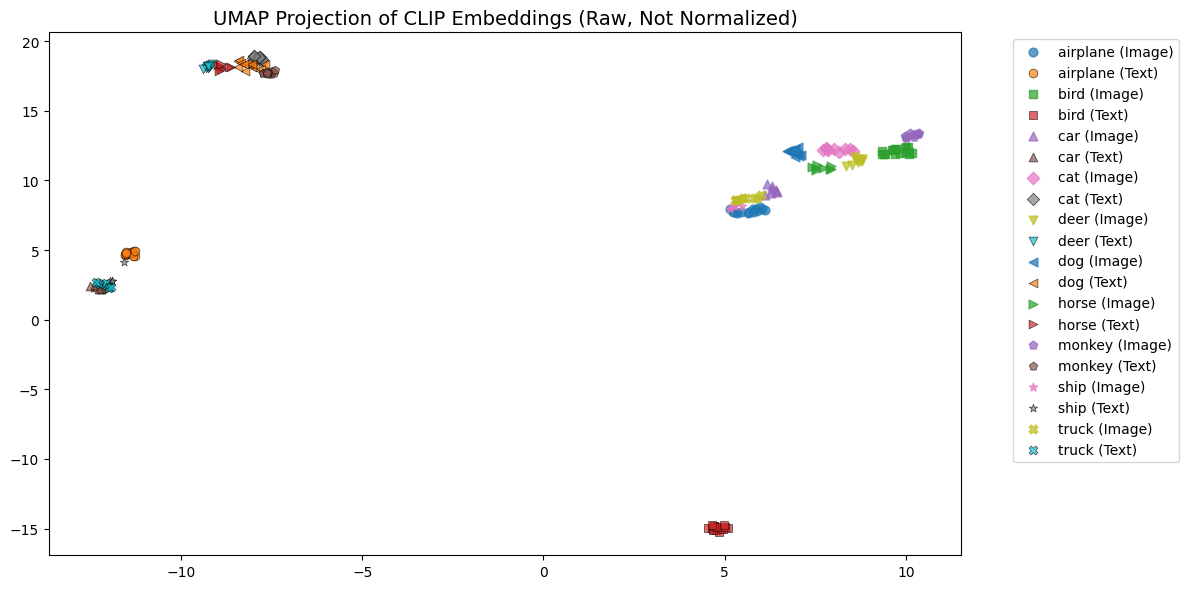

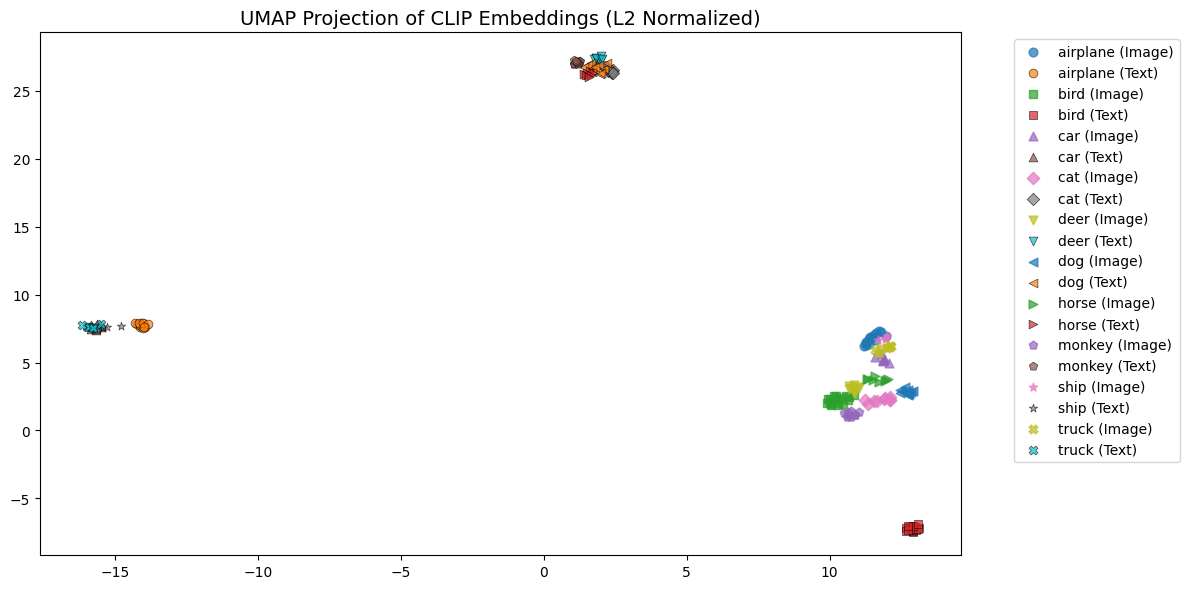

In [ ]:
# --- Prepare data for plotting ---
# For Raw Features
all_features_raw = torch.cat((image_features_raw, text_features_raw), dim=0).numpy()
labels_raw = np.concatenate((true_labels, true_labels)) # Labels are the same for corresponding image-text pairs
modalities_raw = ['Image'] * num_samples + ['Text'] * num_samples # Create modality labels

# For Normalized Features
all_features_norm = torch.cat((image_features_norm, text_features_norm), dim=0).numpy()
# labels_norm and modalities_norm are the same as above

# --- (b) Apply Dimensionality Reduction (Using UMAP) ---
reducer = umap.UMAP(random_state=42, n_components=2) # Use t-SNE if you prefer: TSNE(n_components=2, random_state=42)

print("Fitting UMAP for raw features...")
embedding_raw = reducer.fit_transform(all_features_raw)

print("Fitting UMAP for normalized features...")
embedding_norm = reducer.fit_transform(all_features_norm)

# --- (c) Visualize ---
# Create a function to plot to avoid code duplication
def plot_embeddings(embedding, labels, modalities, title):
    plt.figure(figsize=(12, 6))
    # Create a scatter plot where color=modality and marker=class
    unique_classes = range(10)
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X'] # 10 different markers

    for i, class_id in enumerate(unique_classes):
        # Find indices for points of this specific class
        class_mask = (labels == class_id)
        # Plot IMAGE points for this class
        img_mask = class_mask & (np.array(modalities) == 'Image')
        plt.scatter(embedding[img_mask, 0], embedding[img_mask, 1],
                    label=f'{classes[class_id]} (Image)', marker=markers[i],
                    alpha=0.7, s=40)
        # Plot TEXT points for this class
        txt_mask = class_mask & (np.array(modalities) == 'Text')
        plt.scatter(embedding[txt_mask, 0], embedding[txt_mask, 1],
                    label=f'{classes[class_id]} (Text)', marker=markers[i],
                    alpha=0.7, s=40, edgecolors='k', linewidths=0.5) # Add edge to text points

    plt.title(title, fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot 1: Raw Features
plot_embeddings(embedding_raw, labels_raw, modalities_raw,
                'UMAP Projection of CLIP Embeddings (Raw, Not Normalized)')

# Plot 2: Normalized Features
plot_embeddings(embedding_norm, labels_raw, modalities_raw,
                'UMAP Projection of CLIP Embeddings (L2 Normalized)')

After plotting, I observed that the image modalities are in a single blob altogether, and there are 3 different scattered blobs of text modalities (deer, horse, dog, cat together, bird separate). Normalization made the clusters pull within themselves closer. Something about like things/similar animals (or common feature) being together...

Rotation matrix R shape: (512, 512)
Fitting UMAP for aligned features...


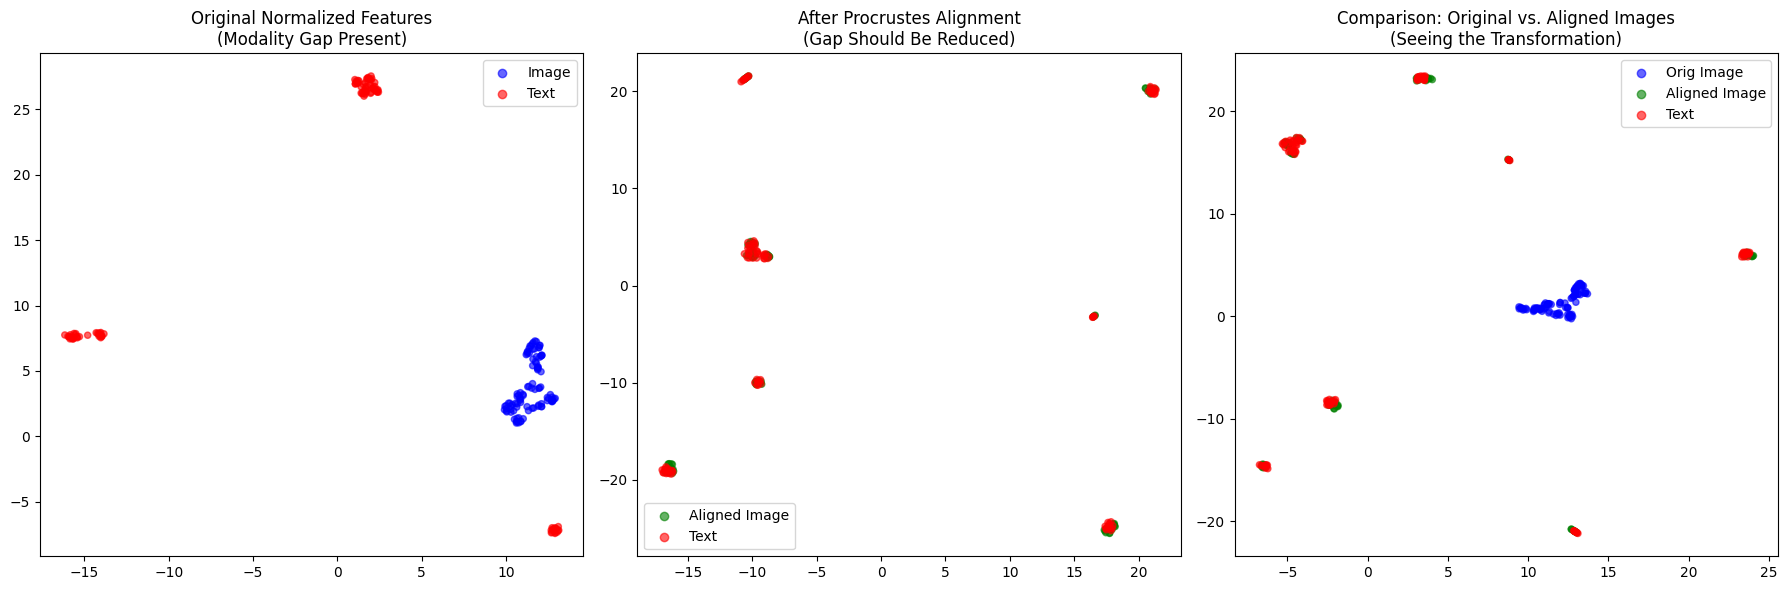

Evaluating accuracy with Procrustes-aligned image features...
Zero-shot Accuracy with Procrustes Alignment: 97.41%
Original 'Basic Prompt' Accuracy: 97.36%


In [ ]:
import numpy as np
from scipy.linalg import orthogonal_procrustes

# --- (b) Pair STL-10 image embeddings with their corresponding text embeddings ---
# We already have these from the previous part!
# image_features_norm: Normalized image features for 100 samples [100, 512]
# text_features_norm: Normalized text features for 100 samples [100, 512]

# These are already paired. image_features_norm[i] corresponds to text_features_norm[i]
# Let's use our normalized features as a good starting point.
X = image_features_norm.numpy() # Image features (source)
Y = text_features_norm.numpy()  # Text features (target)

# --- (c) Learn the optimal rotation matrix R ---
# This function finds R to minimize || X R - Y ||_F
R, scale = orthogonal_procrustes(X, Y)
print(f"Rotation matrix R shape: {R.shape}") # Should be [512, 512]

# --- (d) Apply the rotation transform to the CLIP embeddings ---
# Apply the rotation to the IMAGE embeddings
X_aligned = X @ R # This is the key step: transforming the image features

# Our new aligned image features are in X_aligned
# Our target text features are still Y

# --- (e) Visualize the aligned embeddings ---
# Prepare data for UMAP: combine aligned images and original text
all_features_aligned = np.concatenate((X_aligned, Y), axis=0)
modalities_aligned = ['Aligned Image'] * num_samples + ['Text'] * num_samples

# Reduce dimensionality of the ALIGNED data
print("Fitting UMAP for aligned features...")
embedding_aligned = reducer.fit_transform(all_features_aligned)

# Plot to compare before and after alignment
plt.figure(figsize=(18, 6))

# Plot 1: Original Normalized Features (for comparison)
plt.subplot(1, 3, 1)
colors_orig = ['blue' if m == 'Image' else 'red' for m in modalities_raw]
plt.scatter(embedding_norm[:, 0], embedding_norm[:, 1], c=colors_orig, alpha=0.6, s=20)
plt.title('Original Normalized Features\n(Modality Gap Present)')
plt.scatter([], [], c='blue', label='Image', alpha=0.6)
plt.scatter([], [], c='red', label='Text', alpha=0.6)
plt.legend()

# Plot 2: After Procrustes Alignment
plt.subplot(1, 3, 2)
colors_align = ['green' if m == 'Aligned Image' else 'red' for m in modalities_aligned]
plt.scatter(embedding_aligned[:, 0], embedding_aligned[:, 1], c=colors_align, alpha=0.6, s=20)
plt.title('After Procrustes Alignment\n(Gap Should Be Reduced)')
plt.scatter([], [], c='green', label='Aligned Image', alpha=0.6)
plt.scatter([], [], c='red', label='Text', alpha=0.6)
plt.legend()

# Plot 3: Side-by-Side in Same Space (Advanced)
# To see the shift clearly, let's put original images and aligned images on the same plot
# We need to transform the original image features for this plot
all_features_compare = np.concatenate((X, X_aligned, Y), axis=0) # Orig Img, Aligned Img, Text
modalities_compare = ['Orig Image']*num_samples + ['Aligned Image']*num_samples + ['Text']*num_samples

embedding_compare = reducer.fit_transform(all_features_compare)

plt.subplot(1, 3, 3)
colors_compare = []
for m in modalities_compare:
    if m == 'Orig Image': colors_compare.append('blue')
    elif m == 'Aligned Image': colors_compare.append('green')
    else: colors_compare.append('red')

plt.scatter(embedding_compare[:, 0], embedding_compare[:, 1], c=colors_compare, alpha=0.6, s=20)
plt.title('Comparison: Original vs. Aligned Images\n(Seeing the Transformation)')
plt.scatter([], [], c='blue', label='Orig Image', alpha=0.6)
plt.scatter([], [], c='green', label='Aligned Image', alpha=0.6)
plt.scatter([], [], c='red', label='Text', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

# --- (f) Recompute classification accuracy with the aligned embeddings ---
# Now we use the ROTATED image features for similarity calculation
# We'll create a new function that uses the aligned features

def evaluate_with_alignment(rotation_matrix, test_loader):
    """
    Evaluates accuracy using Procrustes-aligned image features.
    """
    correct = 0
    total = 0

    # Pre-compute text features for all classes (using our best prompt)
    text_inputs = clip.tokenize([f"a photo of a {name}" for name in classes]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu().numpy()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            # Get original image features and normalize
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().numpy()

            # Apply the learned rotation transformation
            image_features_aligned = image_features @ rotation_matrix # <-- The key step

            # Calculate similarity (using numpy)
            similarity = (100.0 * image_features_aligned @ text_features.T)
            # softmax is needed to get probabilities
            similarity = np.exp(similarity - np.max(similarity, axis=1, keepdims=True))
            similarity /= np.sum(similarity, axis=1, keepdims=True)

            predictions = np.argmax(similarity, axis=1)

            # Update counts
            correct += (predictions == labels.numpy()).sum()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

# Evaluate accuracy with alignment
print("Evaluating accuracy with Procrustes-aligned image features...")
accuracy_aligned = evaluate_with_alignment(R, testloader) # You need to define 'testloader' for the full test set
print(f"Zero-shot Accuracy with Procrustes Alignment: {accuracy_aligned:.2f}%")

# Compare with your original result from Part 1 (c)
print(f"Original 'Basic Prompt' Accuracy: {97.36:.2f}%") # Replace 'original_accuracy' with your result from earlier, e.g., 97.36%

Fitting UMAP for Procrustes-aligned features...


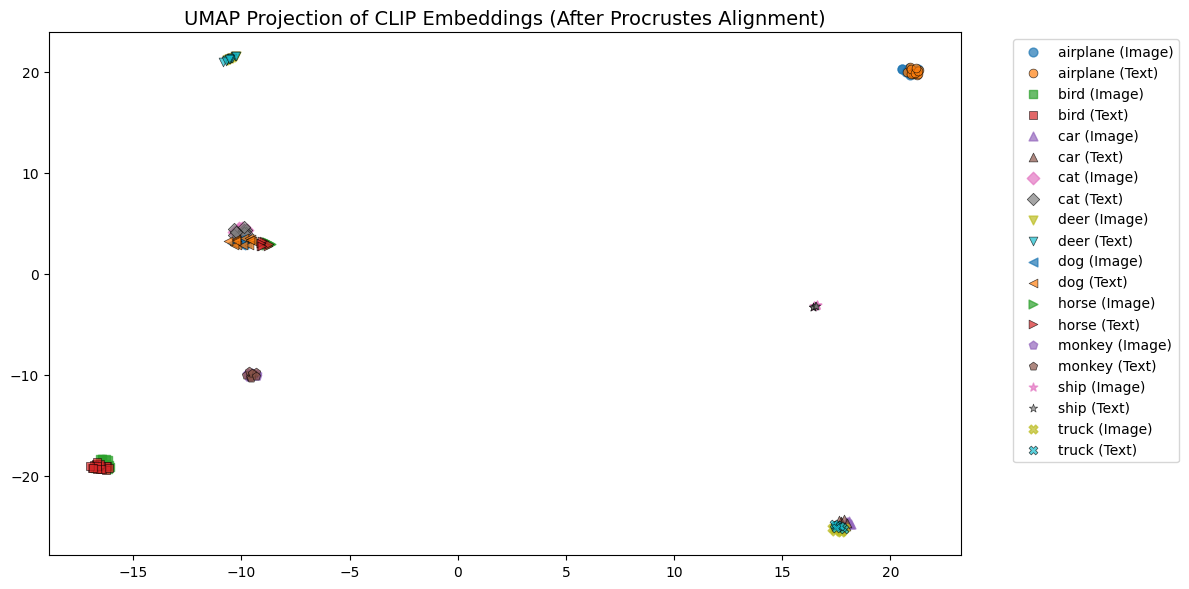

In [ ]:
# --- Prepare data for the Aligned Embeddings Plot ---

# 1. Combine aligned image features and original text features
all_features_aligned = np.concatenate((X_aligned, Y), axis=0)

# 2. The labels and modalities are the same as for the raw/normalized plots
#    because we have the same number of points in the same order.
#    labels_aligned = labels_raw (the concatenated true_labels)
#    modalities_aligned = modalities_raw (the list of ['Image', 'Image', ..., 'Text', 'Text'])

labels_aligned = labels_raw # Since the order of points (image1, image2, ... imageN, text1, text2, ... textN) is unchanged
modalities_aligned = modalities_raw # This is also unchanged

# 3. Apply UMAP to the aligned features to get a 2D projection
print("Fitting UMAP for Procrustes-aligned features...")
embedding_aligned = reducer.fit_transform(all_features_aligned)

# --- (e) Visualize the aligned embeddings ---
# Plot 3: Procrustes Aligned Features
plot_embeddings(embedding_aligned, labels_aligned, modalities_aligned,
                'UMAP Projection of CLIP Embeddings (After Procrustes Alignment)')